<a href="https://colab.research.google.com/github/Wilma1088/mypackage/blob/master/Zindi_Challenge_V13.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Imports**

## **Imported libraries**

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.svm import SVR
from datetime import *
from scipy import stats

from tqdm import tqdm
import math
import random

from scipy.stats import norm, skew #for some statistics

from google.colab import files
import io

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## **Import Datasets**

In [2]:
uploaded = files.upload()

Saving Riders.csv to Riders.csv
Saving Test.csv to Test.csv
Saving Train.csv to Train.csv


**Upload and View: Riders**

In [3]:
riders_df = pd.read_csv(io.BytesIO(uploaded['Riders.csv']))
riders_df.columns= [col.replace(' ', '_') for col in riders_df.columns]
riders_df.head()

,Rider_Id,No_Of_Orders,Age,Average_Rating,No_of_Ratings
0,Rider_Id_396,2946,2298,14.0,1159
1,Rider_Id_479,360,951,13.5,176
2,Rider_Id_648,1746,821,14.3,466
3,Rider_Id_753,314,980,12.5,75
4,Rider_Id_335,536,1113,13.7,156


**Upload and View: Test**

In [4]:
test_df = pd.read_csv(io.BytesIO(uploaded['Test.csv']))
test_df.columns= [col.replace(' ', '_') for col in test_df.columns]
test_df.head()

,Order_No,User_Id,Vehicle_Type,Platform_Type,Personal_or_Business,Placement_-_Day_of_Month,Placement_-_Weekday_(Mo_=_1),Placement_-_Time,Confirmation_-_Day_of_Month,Confirmation_-_Weekday_(Mo_=_1),Confirmation_-_Time,Arrival_at_Pickup_-_Day_of_Month,Arrival_at_Pickup_-_Weekday_(Mo_=_1),Arrival_at_Pickup_-_Time,Pickup_-_Day_of_Month,Pickup_-_Weekday_(Mo_=_1),Pickup_-_Time,Distance_(KM),Temperature,Precipitation_in_millimeters,Pickup_Lat,Pickup_Long,Destination_Lat,Destination_Long,Rider_Id
0,Order_No_19248,User_Id_3355,Bike,3,Business,27,3,4:44:10 PM,27,3,4:44:29 PM,27,3,4:53:04 PM,27,3,5:06:47 PM,8,NaN,NaN,-1.333275,36.870815,-1.305249,36.822390,Rider_Id_192
1,Order_No_12736,User_Id_3647,Bike,3,Business,17,5,12:57:35 PM,17,5,12:59:17 PM,17,5,1:20:27 PM,17,5,1:25:37 PM,5,NaN,NaN,-1.272639,36.794723,-1.277007,36.823907,Rider_Id_868
2,Order_No_768,User_Id_2154,Bike,3,Business,27,4,11:08:14 AM,27,4,11:25:05 AM,27,4,11:33:20 AM,27,4,11:57:54 AM,5,22.8,NaN,-1.290894,36.822971,-1.276574,36.851365,Rider_Id_26
3,Order_No_15332,User_Id_2910,Bike,3,Business,17,1,1:51:35 PM,17,1,1:53:27 PM,17,1,2:02:41 PM,17,1,2:16:52 PM,5,24.5,NaN,-1.290503,36.809646,-1.303382,36.790658,Rider_Id_685
4,Order_No_21373,User_Id_1205,Bike,3,Business,11,2,11:30:28 AM,11,2,11:34:45 AM,11,2,11:47:19 AM,11,2,11:56:04 AM,6,24.4,NaN,-1.281081,36.814423,-1.266467,36.792161,Rider_Id_858


**Upload and View: Train**

In [5]:
train_df = pd.read_csv(io.BytesIO(uploaded['Train.csv']))
train_df.columns= [col.replace(' ', '_') for col in train_df.columns]
train_df.head()

,Order_No,User_Id,Vehicle_Type,Platform_Type,Personal_or_Business,Placement_-_Day_of_Month,Placement_-_Weekday_(Mo_=_1),Placement_-_Time,Confirmation_-_Day_of_Month,Confirmation_-_Weekday_(Mo_=_1),Confirmation_-_Time,Arrival_at_Pickup_-_Day_of_Month,Arrival_at_Pickup_-_Weekday_(Mo_=_1),Arrival_at_Pickup_-_Time,Pickup_-_Day_of_Month,Pickup_-_Weekday_(Mo_=_1),Pickup_-_Time,Arrival_at_Destination_-_Day_of_Month,Arrival_at_Destination_-_Weekday_(Mo_=_1),Arrival_at_Destination_-_Time,Distance_(KM),Temperature,Precipitation_in_millimeters,Pickup_Lat,Pickup_Long,Destination_Lat,Destination_Long,Rider_Id,Time_from_Pickup_to_Arrival
0,Order_No_4211,User_Id_633,Bike,3,Business,9,5,9:35:46 AM,9,5,9:40:10 AM,9,5,10:04:47 AM,9,5,10:27:30 AM,9,5,10:39:55 AM,4,20.4,NaN,-1.317755,36.830370,-1.300406,36.829741,Rider_Id_432,745
1,Order_No_25375,User_Id_2285,Bike,3,Personal,12,5,11:16:16 AM,12,5,11:23:21 AM,12,5,11:40:22 AM,12,5,11:44:09 AM,12,5,12:17:22 PM,16,26.4,NaN,-1.351453,36.899315,-1.295004,36.814358,Rider_Id_856,1993
2,Order_No_1899,User_Id_265,Bike,3,Business,30,2,12:39:25 PM,30,2,12:42:44 PM,30,2,12:49:34 PM,30,2,12:53:03 PM,30,2,1:00:38 PM,3,NaN,NaN,-1.308284,36.843419,-1.300921,36.828195,Rider_Id_155,455
3,Order_No_9336,User_Id_1402,Bike,3,Business,15,5,9:25:34 AM,15,5,9:26:05 AM,15,5,9:37:56 AM,15,5,9:43:06 AM,15,5,10:05:27 AM,9,19.2,NaN,-1.281301,36.832396,-1.257147,36.795063,Rider_Id_855,1341
4,Order_No_27883,User_Id_1737,Bike,1,Personal,13,1,9:55:18 AM,13,1,9:56:18 AM,13,1,10:03:53 AM,13,1,10:05:23 AM,13,1,10:25:37 AM,9,15.4,NaN,-1.266597,36.792118,-1.295041,36.809817,Rider_Id_770,1214


## **Merging Dataframes**

**Concatenating Train and Test**

In [6]:
df=pd.concat([train_df, test_df])
df.head()

,Order_No,User_Id,Vehicle_Type,Platform_Type,Personal_or_Business,Placement_-_Day_of_Month,Placement_-_Weekday_(Mo_=_1),Placement_-_Time,Confirmation_-_Day_of_Month,Confirmation_-_Weekday_(Mo_=_1),Confirmation_-_Time,Arrival_at_Pickup_-_Day_of_Month,Arrival_at_Pickup_-_Weekday_(Mo_=_1),Arrival_at_Pickup_-_Time,Pickup_-_Day_of_Month,Pickup_-_Weekday_(Mo_=_1),Pickup_-_Time,Arrival_at_Destination_-_Day_of_Month,Arrival_at_Destination_-_Weekday_(Mo_=_1),Arrival_at_Destination_-_Time,Distance_(KM),Temperature,Precipitation_in_millimeters,Pickup_Lat,Pickup_Long,Destination_Lat,Destination_Long,Rider_Id,Time_from_Pickup_to_Arrival
0,Order_No_4211,User_Id_633,Bike,3,Business,9,5,9:35:46 AM,9,5,9:40:10 AM,9,5,10:04:47 AM,9,5,10:27:30 AM,9.0,5.0,10:39:55 AM,4,20.4,NaN,-1.317755,36.830370,-1.300406,36.829741,Rider_Id_432,745.0
1,Order_No_25375,User_Id_2285,Bike,3,Personal,12,5,11:16:16 AM,12,5,11:23:21 AM,12,5,11:40:22 AM,12,5,11:44:09 AM,12.0,5.0,12:17:22 PM,16,26.4,NaN,-1.351453,36.899315,-1.295004,36.814358,Rider_Id_856,1993.0
2,Order_No_1899,User_Id_265,Bike,3,Business,30,2,12:39:25 PM,30,2,12:42:44 PM,30,2,12:49:34 PM,30,2,12:53:03 PM,30.0,2.0,1:00:38 PM,3,NaN,NaN,-1.308284,36.843419,-1.300921,36.828195,Rider_Id_155,455.0
3,Order_No_9336,User_Id_1402,Bike,3,Business,15,5,9:25:34 AM,15,5,9:26:05 AM,15,5,9:37:56 AM,15,5,9:43:06 AM,15.0,5.0,10:05:27 AM,9,19.2,NaN,-1.281301,36.832396,-1.257147,36.795063,Rider_Id_855,1341.0
4,Order_No_27883,User_Id_1737,Bike,1,Personal,13,1,9:55:18 AM,13,1,9:56:18 AM,13,1,10:03:53 AM,13,1,10:05:23 AM,13.0,1.0,10:25:37 AM,9,15.4,NaN,-1.266597,36.792118,-1.295041,36.809817,Rider_Id_770,1214.0


**Merging Riders to Concatenated Dataframe**

In [7]:
df = df.merge(riders_df, left_on='Rider_Id', right_on='Rider_Id', how='left')

**View Merged Dataframe**

In [8]:
df.shape

(28269, 33)

In [9]:
df.head()

,Order_No,User_Id,Vehicle_Type,Platform_Type,Personal_or_Business,Placement_-_Day_of_Month,Placement_-_Weekday_(Mo_=_1),Placement_-_Time,Confirmation_-_Day_of_Month,Confirmation_-_Weekday_(Mo_=_1),Confirmation_-_Time,Arrival_at_Pickup_-_Day_of_Month,Arrival_at_Pickup_-_Weekday_(Mo_=_1),Arrival_at_Pickup_-_Time,Pickup_-_Day_of_Month,Pickup_-_Weekday_(Mo_=_1),Pickup_-_Time,Arrival_at_Destination_-_Day_of_Month,Arrival_at_Destination_-_Weekday_(Mo_=_1),Arrival_at_Destination_-_Time,Distance_(KM),Temperature,Precipitation_in_millimeters,Pickup_Lat,Pickup_Long,Destination_Lat,Destination_Long,Rider_Id,Time_from_Pickup_to_Arrival,No_Of_Orders,Age,Average_Rating,No_of_Ratings
0,Order_No_4211,User_Id_633,Bike,3,Business,9,5,9:35:46 AM,9,5,9:40:10 AM,9,5,10:04:47 AM,9,5,10:27:30 AM,9.0,5.0,10:39:55 AM,4,20.4,NaN,-1.317755,36.830370,-1.300406,36.829741,Rider_Id_432,745.0,1637,1309,13.8,549
1,Order_No_25375,User_Id_2285,Bike,3,Personal,12,5,11:16:16 AM,12,5,11:23:21 AM,12,5,11:40:22 AM,12,5,11:44:09 AM,12.0,5.0,12:17:22 PM,16,26.4,NaN,-1.351453,36.899315,-1.295004,36.814358,Rider_Id_856,1993.0,396,339,13.6,69
2,Order_No_1899,User_Id_265,Bike,3,Business,30,2,12:39:25 PM,30,2,12:42:44 PM,30,2,12:49:34 PM,30,2,12:53:03 PM,30.0,2.0,1:00:38 PM,3,NaN,NaN,-1.308284,36.843419,-1.300921,36.828195,Rider_Id_155,455.0,1023,242,12.5,114
3,Order_No_9336,User_Id_1402,Bike,3,Business,15,5,9:25:34 AM,15,5,9:26:05 AM,15,5,9:37:56 AM,15,5,9:43:06 AM,15.0,5.0,10:05:27 AM,9,19.2,NaN,-1.281301,36.832396,-1.257147,36.795063,Rider_Id_855,1341.0,886,283,14.5,113
4,Order_No_27883,User_Id_1737,Bike,1,Personal,13,1,9:55:18 AM,13,1,9:56:18 AM,13,1,10:03:53 AM,13,1,10:05:23 AM,13.0,1.0,10:25:37 AM,9,15.4,NaN,-1.266597,36.792118,-1.295041,36.809817,Rider_Id_770,1214.0,2311,872,14.1,533


In [10]:
#Drop rows that were not provided in the test dataset, 
#excl 'Time_from_Pickup_to_Arrival as this will be our Y variable
df= df.drop(['Arrival_at_Destination_-_Day_of_Month', 'Arrival_at_Destination_-_Weekday_(Mo_=_1)', 'Arrival_at_Destination_-_Time'],axis=1) 

# **EDA**

## **Cleaning Data**

#### **Manual Inspection and Dropping of Redundent Columns**

In [12]:
df.head()

,Order_No,User_Id,Vehicle_Type,Platform_Type,Personal_or_Business,Placement_-_Day_of_Month,Placement_-_Weekday_(Mo_=_1),Placement_-_Time,Confirmation_-_Day_of_Month,Confirmation_-_Weekday_(Mo_=_1),Confirmation_-_Time,Arrival_at_Pickup_-_Day_of_Month,Arrival_at_Pickup_-_Weekday_(Mo_=_1),Arrival_at_Pickup_-_Time,Pickup_-_Day_of_Month,Pickup_-_Weekday_(Mo_=_1),Pickup_-_Time,Distance_(KM),Temperature,Precipitation_in_millimeters,Pickup_Lat,Pickup_Long,Destination_Lat,Destination_Long,Rider_Id,Time_from_Pickup_to_Arrival,No_Of_Orders,Age,Average_Rating,No_of_Ratings
0,Order_No_4211,User_Id_633,Bike,3,Business,9,5,9:35:46 AM,9,5,9:40:10 AM,9,5,10:04:47 AM,9,5,10:27:30 AM,4,20.4,NaN,-1.317755,36.830370,-1.300406,36.829741,Rider_Id_432,745.0,1637,1309,13.8,549
1,Order_No_25375,User_Id_2285,Bike,3,Personal,12,5,11:16:16 AM,12,5,11:23:21 AM,12,5,11:40:22 AM,12,5,11:44:09 AM,16,26.4,NaN,-1.351453,36.899315,-1.295004,36.814358,Rider_Id_856,1993.0,396,339,13.6,69
2,Order_No_1899,User_Id_265,Bike,3,Business,30,2,12:39:25 PM,30,2,12:42:44 PM,30,2,12:49:34 PM,30,2,12:53:03 PM,3,NaN,NaN,-1.308284,36.843419,-1.300921,36.828195,Rider_Id_155,455.0,1023,242,12.5,114
3,Order_No_9336,User_Id_1402,Bike,3,Business,15,5,9:25:34 AM,15,5,9:26:05 AM,15,5,9:37:56 AM,15,5,9:43:06 AM,9,19.2,NaN,-1.281301,36.832396,-1.257147,36.795063,Rider_Id_855,1341.0,886,283,14.5,113
4,Order_No_27883,User_Id_1737,Bike,1,Personal,13,1,9:55:18 AM,13,1,9:56:18 AM,13,1,10:03:53 AM,13,1,10:05:23 AM,9,15.4,NaN,-1.266597,36.792118,-1.295041,36.809817,Rider_Id_770,1214.0,2311,872,14.1,533


In [14]:
#Day of Month and Weekday values appear to be the same across Placement, Confirmation
#Arrival at Pickup, dropping all excl Pickup Day of Month and Pickup Weekday
#Placement, Confirmation, Arrival at Pickup times will also be dropped as only 
#Pickup time will be used in model
df= df.drop(['Placement_-_Day_of_Month', 'Placement_-_Weekday_(Mo_=_1)', 
             'Placement_-_Time', 'Confirmation_-_Day_of_Month', 
             'Confirmation_-_Weekday_(Mo_=_1)', 'Confirmation_-_Time', 
             'Arrival_at_Pickup_-_Day_of_Month', 'Arrival_at_Pickup_-_Weekday_(Mo_=_1)',
             'Arrival_at_Pickup_-_Time'],axis=1) 

### **Dealing with Single Value Columns**

**Indentifying Single Value Columns**

In [15]:
df.nunique()

Order_No                        28269
User_Id                          3782
Vehicle_Type                        1
Platform_Type                       4
Personal_or_Business                2
Pickup_-_Day_of_Month              31
Pickup_-_Weekday_(Mo_=_1)           7
Pickup_-_Time                   19161
Distance_(KM)                      46
Temperature                       188
Precipitation_in_millimeters       56
Pickup_Lat                       4393
Pickup_Long                      4377
Destination_Lat                  6246
Destination_Long                 6203
Rider_Id                          952
Time_from_Pickup_to_Arrival      4067
No_Of_Orders                      807
Age                               719
Average_Rating                     45
No_of_Ratings                     549
dtype: int64

**Dropping Single Value Columns**

In [16]:
for col in df.columns:
    if len(df[col].unique()) == 1:
        df.drop(col,inplace=True,axis=1)

In [17]:
df.shape

(28269, 20)

### **Dealing with Data Types**

**Visualising Data Types**

In [18]:
df.dtypes

Order_No                         object
User_Id                          object
Platform_Type                     int64
Personal_or_Business             object
Pickup_-_Day_of_Month             int64
Pickup_-_Weekday_(Mo_=_1)         int64
Pickup_-_Time                    object
Distance_(KM)                     int64
Temperature                     float64
Precipitation_in_millimeters    float64
Pickup_Lat                      float64
Pickup_Long                     float64
Destination_Lat                 float64
Destination_Long                float64
Rider_Id                         object
Time_from_Pickup_to_Arrival     float64
No_Of_Orders                      int64
Age                               int64
Average_Rating                  float64
No_of_Ratings                     int64
dtype: object

**Amending Data Types**

In [19]:
df['Order_No'] = df['Order_No'].str.replace(r'\D', '')

In [20]:
df['User_Id'] = df['User_Id'].str.replace(r'\D', '')

In [21]:
df['Rider_Id'] = df['Rider_Id'].str.replace(r'\D', '')

In [22]:
df['Pickup_-_Time'] = pd.to_timedelta(df['Pickup_-_Time'])
tm = pd.to_timedelta(['00:00:00','12:00:00','16:00:00','20:00:00', '24:00:00'])
ctg = ['Morning','Afternoon','Evening','Night']
df['Pickup_-_Time'] = pd.cut(df['Pickup_-_Time'], bins=tm, labels=ctg)

In [23]:
df.head()

,Order_No,User_Id,Platform_Type,Personal_or_Business,Pickup_-_Day_of_Month,Pickup_-_Weekday_(Mo_=_1),Pickup_-_Time,Distance_(KM),Temperature,Precipitation_in_millimeters,Pickup_Lat,Pickup_Long,Destination_Lat,Destination_Long,Rider_Id,Time_from_Pickup_to_Arrival,No_Of_Orders,Age,Average_Rating,No_of_Ratings
0,4211,633,3,Business,9,5,Morning,4,20.4,NaN,-1.317755,36.830370,-1.300406,36.829741,432,745.0,1637,1309,13.8,549
1,25375,2285,3,Personal,12,5,Morning,16,26.4,NaN,-1.351453,36.899315,-1.295004,36.814358,856,1993.0,396,339,13.6,69
2,1899,265,3,Business,30,2,Afternoon,3,NaN,NaN,-1.308284,36.843419,-1.300921,36.828195,155,455.0,1023,242,12.5,114
3,9336,1402,3,Business,15,5,Morning,9,19.2,NaN,-1.281301,36.832396,-1.257147,36.795063,855,1341.0,886,283,14.5,113
4,27883,1737,1,Personal,13,1,Morning,9,15.4,NaN,-1.266597,36.792118,-1.295041,36.809817,770,1214.0,2311,872,14.1,533


**Assigning Dummie Variables**

Platform Dummies

In [24]:
df = pd.get_dummies(data=df, columns=['Platform_Type', 'Pickup_-_Time'])

Business Type Dummies

In [25]:
df["Personal_or_Business"] = pd.get_dummies(df["Personal_or_Business"],drop_first=True)

In [26]:
df.head()

,Order_No,User_Id,Personal_or_Business,Pickup_-_Day_of_Month,Pickup_-_Weekday_(Mo_=_1),Distance_(KM),Temperature,Precipitation_in_millimeters,Pickup_Lat,Pickup_Long,Destination_Lat,Destination_Long,Rider_Id,Time_from_Pickup_to_Arrival,No_Of_Orders,Age,Average_Rating,No_of_Ratings,Platform_Type_1,Platform_Type_2,Platform_Type_3,Platform_Type_4,Pickup_-_Time_Morning,Pickup_-_Time_Afternoon,Pickup_-_Time_Evening,Pickup_-_Time_Night
0,4211,633,0,9,5,4,20.4,NaN,-1.317755,36.830370,-1.300406,36.829741,432,745.0,1637,1309,13.8,549,0,0,1,0,1,0,0,0
1,25375,2285,1,12,5,16,26.4,NaN,-1.351453,36.899315,-1.295004,36.814358,856,1993.0,396,339,13.6,69,0,0,1,0,1,0,0,0
2,1899,265,0,30,2,3,NaN,NaN,-1.308284,36.843419,-1.300921,36.828195,155,455.0,1023,242,12.5,114,0,0,1,0,0,1,0,0
3,9336,1402,0,15,5,9,19.2,NaN,-1.281301,36.832396,-1.257147,36.795063,855,1341.0,886,283,14.5,113,0,0,1,0,1,0,0,0
4,27883,1737,1,13,1,9,15.4,NaN,-1.266597,36.792118,-1.295041,36.809817,770,1214.0,2311,872,14.1,533,1,0,0,0,1,0,0,0


### **Dealing with Missing Values**

**View Percentage of Missing Values**

In [27]:
missing = round(df.isnull().sum() * 100 / len(df))
print(missing)

Order_No                         0.0
User_Id                          0.0
Personal_or_Business             0.0
Pickup_-_Day_of_Month            0.0
Pickup_-_Weekday_(Mo_=_1)        0.0
Distance_(KM)                    0.0
Temperature                     21.0
Precipitation_in_millimeters    97.0
Pickup_Lat                       0.0
Pickup_Long                      0.0
Destination_Lat                  0.0
Destination_Long                 0.0
Rider_Id                         0.0
Time_from_Pickup_to_Arrival     25.0
No_Of_Orders                     0.0
Age                              0.0
Average_Rating                   0.0
No_of_Ratings                    0.0
Platform_Type_1                  0.0
Platform_Type_2                  0.0
Platform_Type_3                  0.0
Platform_Type_4                  0.0
Pickup_-_Time_Morning            0.0
Pickup_-_Time_Afternoon          0.0
Pickup_-_Time_Evening            0.0
Pickup_-_Time_Night              0.0
dtype: float64


In [28]:
df= df.drop(['Precipitation_in_millimeters'],axis=1) 

In [29]:
df['Temperature'] = df['Temperature'].fillna(df.groupby(['Pickup_-_Day_of_Month', 'Pickup_-_Weekday_(Mo_=_1)'])['Temperature'].transform('mean'))
df['Temperature'] = df['Temperature'].fillna(df['Temperature'].mean())

In [30]:
df['Time_from_Pickup_to_Arrival'] = df['Time_from_Pickup_to_Arrival'].fillna(df['Time_from_Pickup_to_Arrival'].mean())

## **Correlation**

### **Dealing with Correlation and Multicollinearity**

#### **Correlation**

**Visualising Correlation**

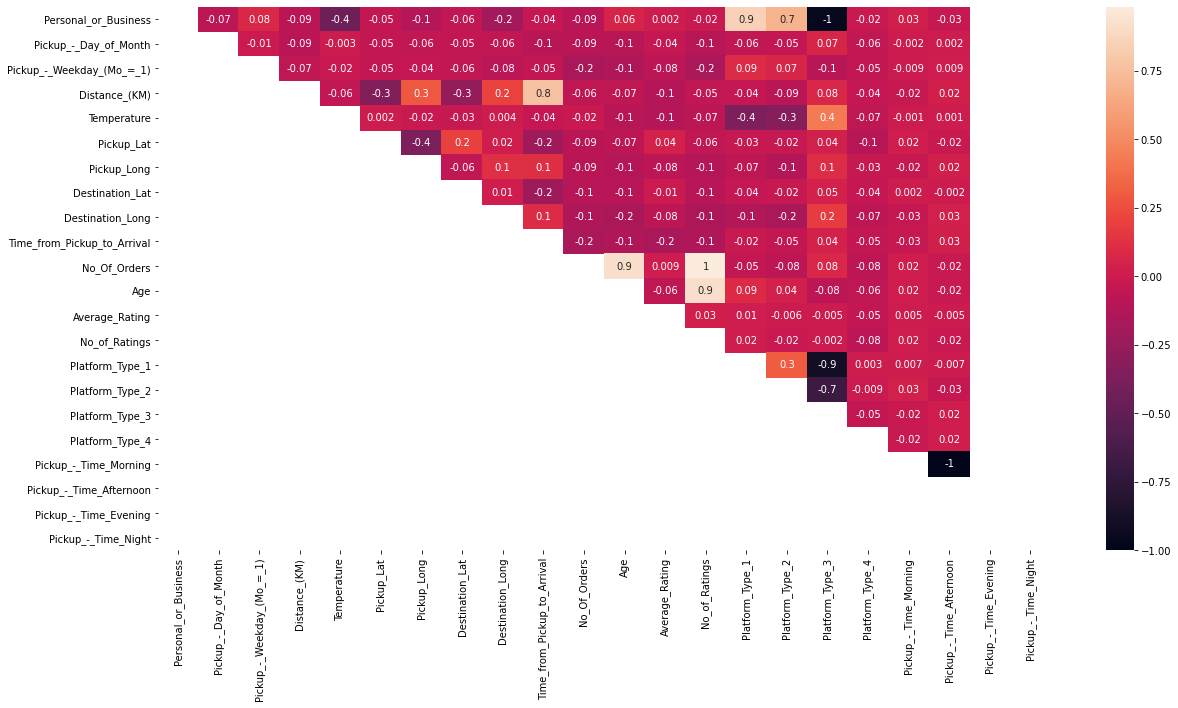

In [31]:
plt.figure(figsize=(20,10))
data = df.corr()
mask = np.tril(data)
sns.heatmap(data.corr(), annot = True, fmt='.1g', mask= mask)

**Dropping Highly Correlated Columns**

In [32]:
# Create correlation matrix
corr_matrix = df.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

In [33]:
# Drop features 
df.drop(df[to_drop], axis=1)

,Order_No,User_Id,Personal_or_Business,Pickup_-_Day_of_Month,Pickup_-_Weekday_(Mo_=_1),Distance_(KM),Temperature,Pickup_Lat,Pickup_Long,Destination_Lat,Destination_Long,Rider_Id,Time_from_Pickup_to_Arrival,No_Of_Orders,Age,Average_Rating,No_of_Ratings,Platform_Type_1,Platform_Type_2,Platform_Type_3,Platform_Type_4,Pickup_-_Time_Morning,Pickup_-_Time_Evening,Pickup_-_Time_Night
0,4211,633,0,9,5,4,20.400000,-1.317755,36.830370,-1.300406,36.829741,432,745.000000,1637,1309,13.8,549,0,0,1,0,1,0,0
1,25375,2285,1,12,5,16,26.400000,-1.351453,36.899315,-1.295004,36.814358,856,1993.000000,396,339,13.6,69,0,0,1,0,1,0,0
2,1899,265,0,30,2,3,23.530108,-1.308284,36.843419,-1.300921,36.828195,155,455.000000,1023,242,12.5,114,0,0,1,0,0,0,0
3,9336,1402,0,15,5,9,19.200000,-1.281301,36.832396,-1.257147,36.795063,855,1341.000000,886,283,14.5,113,0,0,1,0,1,0,0
4,27883,1737,1,13,1,9,15.400000,-1.266597,36.792118,-1.295041,36.809817,770,1214.000000,2311,872,14.1,533,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28264,3612,2587,0,7,1,5,24.800000,-1.258414,36.804800,-1.288780,36.816831,362,1556.920947,1018,504,13.1,87,0,0,1,0,1,0,0
28265,7657,3547,0,10,3,22,30.700000,-1.276141,36.771084,-1.316098,36.913164,669,1556.920947,6728,2702,13.9,2027,0,0,1,0,1,0,0
28266,1969,136,0,5,3,10,25.100000,-1.301446,36.766138,-1.264960,36.798178,379,1556.920947,1601,1337,13.7,441,0,0,1,0,1,0,0
28267,10591,1979,1,29,2,18,23.600000,-1.248404,36.678276,-1.272027,36.817411,474,1556.920947,225,878,14.1,66,0,0,1,0,1,0,0


In [34]:
df.shape

(28269, 25)

### **Multicollinearity**

**Visualising Multicollinearity**

In [36]:
df = df.apply(pd.to_numeric)

In [37]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calc_vif(df1):

    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = df1.columns
    vif["VIF"] = [variance_inflation_factor(df1.values, i) for i in range(df1.shape[1])]

    return(vif)

In [38]:
df1 = df.iloc[:,:-1]
calc_vif(df1)

/usr/local/lib/python3.6/dist-packages/statsmodels/stats/outliers_influence.py:185: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
/usr/local/lib/python3.6/dist-packages/statsmodels/regression/linear_model.py:1636: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


,variables,VIF
0,Order_No,1.000912
1,User_Id,1.026298
2,Personal_or_Business,2.332432
3,Pickup_-_Day_of_Month,1.001881
4,Pickup_-_Weekday_(Mo_=_1),1.007491
5,Distance_(KM),1.435633
6,Temperature,1.043016
7,Pickup_Lat,1.075011
8,Pickup_Long,1.063572
9,Destination_Lat,1.023798


**Dropping Multicollinear Features**

In [39]:
df.head()

,Order_No,User_Id,Personal_or_Business,Pickup_-_Day_of_Month,Pickup_-_Weekday_(Mo_=_1),Distance_(KM),Temperature,Pickup_Lat,Pickup_Long,Destination_Lat,Destination_Long,Rider_Id,Time_from_Pickup_to_Arrival,No_Of_Orders,Age,Average_Rating,No_of_Ratings,Platform_Type_1,Platform_Type_2,Platform_Type_3,Platform_Type_4,Pickup_-_Time_Morning,Pickup_-_Time_Afternoon,Pickup_-_Time_Evening,Pickup_-_Time_Night
0,4211,633,0,9,5,4,20.400000,-1.317755,36.830370,-1.300406,36.829741,432,745.0,1637,1309,13.8,549,0,0,1,0,1,0,0,0
1,25375,2285,1,12,5,16,26.400000,-1.351453,36.899315,-1.295004,36.814358,856,1993.0,396,339,13.6,69,0,0,1,0,1,0,0,0
2,1899,265,0,30,2,3,23.530108,-1.308284,36.843419,-1.300921,36.828195,155,455.0,1023,242,12.5,114,0,0,1,0,0,1,0,0
3,9336,1402,0,15,5,9,19.200000,-1.281301,36.832396,-1.257147,36.795063,855,1341.0,886,283,14.5,113,0,0,1,0,1,0,0,0
4,27883,1737,1,13,1,9,15.400000,-1.266597,36.792118,-1.295041,36.809817,770,1214.0,2311,872,14.1,533,1,0,0,0,1,0,0,0


In [40]:
# train test split
y = df[:len(train_df)][['Time_from_Pickup_to_Arrival']]
x_train = df[:len(train_df)].drop('Time_from_Pickup_to_Arrival',axis=1)
x_test = df[len(train_df):].drop('Time_from_Pickup_to_Arrival',axis=1)
x = df[:len(train_df)].drop('Time_from_Pickup_to_Arrival',axis=1)

# **Modelling**

Linear Regression

In [41]:
lr = LinearRegression()
####try different models on different versions, go wild! to see results

In [42]:
# Using just the training dataset to test model accuracy 
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test= train_test_split(x, y, test_size= 0.2, random_state=42) 

In [43]:
lr.fit(x_train,y_train)

preds = lr.predict(x_test)

In [44]:
def rmse(y_test, y_predict):
    return np.sqrt(mean_squared_error(y_test, y_predict))

In [45]:
rmse(y_test, preds)

799.2916388326498

In [46]:
from sklearn.metrics import r2_score

In [47]:
r2_score(y_test, preds) 
### checking for accuracy

0.34226234548921675

Random Forest Regression

In [52]:
sc = StandardScaler()
x_sc = sc.fit_transform(x)

In [53]:
x_train, x_test, y_train,y_test = train_test_split(x_sc, y,test_size=0.2,random_state= 42)

In [54]:
regressor = RandomForestRegressor(n_estimators= 120, random_state= 42)
####try different models on different versions

In [55]:
regressor.fit(x_train, y_train)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=120, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [56]:
y_predict = regressor.predict(x_test)

In [57]:
def rmse(y_test, y_predict):
    return np.sqrt(mean_squared_error(y_test, y_predict))

In [58]:
rmse(y_test, y_predict)

778.9156319698918

In [59]:
from sklearn.metrics import r2_score

In [60]:
r2_score(y_test, y_predict) 

0.3753697613070156